In [1]:
import numpy as np
import torch
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

import reservoir
import reckernel
import kuramoto
%load_ext autoreload
%autoreload 2

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
today = '200609'

# Convergence study

In this notebook, we would like to study whether Reservoir Computing and Structured Reservoir Computing converge towards a Recurrent Kernel.

These parameters can be changed:
- random_projection: to switch between RC and SRC
- redraw: to redraw the weights at each iteration
- res_scale: scale of the reservoir weights (stable if <1, may diverge if >1)
- rc_fun, rk_fun: activation functions of RC and RK

In [17]:
## Choose main parameters
random_projection = 'gaussian'  # "gaussian" for RC, "structured" for SRC
redraw = True  # to choose if weights are redrawn at each iteration
res_scale = .5  # scale of reservoir in dynamics

# Activation functions here (by uncommenting one line)
# rc_fun, rk_fun = 'linear', 'linear'
# rc_fun, rk_fun = 'erf', 'arcsin'
# rc_fun, rk_fun = 'cos_rbf', 'rbf'
# rc_fun, rk_fun = 'heaviside', 'acos heaviside'
# rc_fun, rk_fun = 'sign', 'asin sign'
rc_fun, rk_fun = 'relu', 'acos relu'

## Other parameters (they don't have to be changed)
n_rep = 10
input_len_range = [10]  # np.arange(start=1, stop=10, step=1)
input_dim = 100  # dimension of the time series, larger reduces the variance of the final result
input_scale = .5  # scale of input in reservoir dynamics
n_input = 50 # number of time series, usually 50 is enough

## Choose the range of the reservoir sizes here
if random_projection == 'gaussian':
    n_res_range = np.logspace(2, 3.5, num=4, dtype=int)
elif random_projection == 'structured':
    first_pow = 8
    last_pow = 20  # 2**20 => ~10^6
    n_res_range = np.logspace(first_pow, last_pow, num=(last_pow-first_pow)/4+1, base=2., dtype=int) - input_dim

# Define Recurrent Kernel
loss = torch.nn.MSELoss()
RK = reckernel.RecKernel(function=rk_fun, res_scale=res_scale, input_scale=input_scale, memory_efficient=False)

mse_mat = torch.zeros(len(input_len_range), len(n_res_range), n_rep)
for k in range(n_rep):
    torch.manual_seed(k)
    for i, n_res in tqdm(enumerate(n_res_range)):
        initial_states = torch.randn(n_input, n_res).to(device) / np.sqrt(n_res)
        initial_K = initial_states @ initial_states.T
        model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                              f=rc_fun, random_projection=random_projection, seed=k, redraw=redraw)
        for j, input_len in (enumerate(input_len_range)):
            input_data = torch.randn(n_input, input_len, input_dim).to(device) / np.sqrt(input_dim)

            K = RK.forward(input_data, initial_K=initial_K)
            
            X_final = torch.zeros((n_input,n_res)).to(device)
            for n_in in range(n_input):
                X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state=initial_states[n_in, :]).to(device)
                X_final[n_in,:] = X[-1,:]
            K_hat = torch.matmul(X_final,X_final.t())
            
            mse_mat[j, i, k] = loss(K_hat,K)

4it [00:37,  9.29s/it]
4it [00:37,  9.29s/it]
4it [00:37,  9.35s/it]
4it [00:37,  9.29s/it]
4it [00:37,  9.29s/it]
4it [00:37,  9.28s/it]
4it [00:37,  9.29s/it]
4it [00:37,  9.29s/it]
4it [00:37,  9.30s/it]
4it [00:37,  9.30s/it]


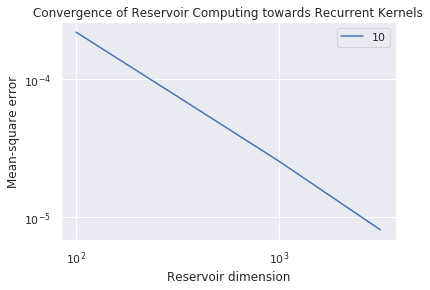

In [18]:
# Plots
ncurves = 10
plt.loglog(n_res_range, torch.mean(mse_mat, axis=2)[:ncurves, :].T)
plt.legend(input_len_range[:ncurves])
plt.title('Convergence of Reservoir Computing towards Recurrent Kernels')
plt.xlabel('Reservoir dimension')
plt.ylabel('Mean-square error');

In [19]:
np.save('out/' + today + '_conv_' + random_projection + 
        '_' + rc_fun + '_res' + str(res_scale) + '_redraw' + str(redraw), 
        mse_mat)

# Plots

In [23]:
erf_rc = np.load('out/200609_conv_gaussian_erf_res0.5_redrawFalse.npy')
erf_rc_r = np.load('out/200609_conv_gaussian_erf_res0.5_redrawTrue.npy')
erf_src = np.load('out/200609_conv_structured_erf_res0.5_redrawFalse.npy')
erf_src_r = np.load('out/200609_conv_structured_erf_res0.5_redrawTrue.npy')
cos_rc = np.load('out/200609_conv_gaussian_cos_rbf_res0.5_redrawFalse.npy')
cos_rc_r = np.load('out/200609_conv_gaussian_cos_rbf_res0.5_redrawTrue.npy')
cos_src = np.load('out/200609_conv_structured_cos_rbf_res0.5_redrawFalse.npy')
cos_src_r = np.load('out/200609_conv_structured_cos_rbf_res0.5_redrawTrue.npy')
lin_rc = np.load('out/200609_conv_gaussian_linear_res0.5_redrawFalse.npy')
lin_rc_r = np.load('out/200609_conv_gaussian_linear_res0.5_redrawTrue.npy')
lin_src = np.load('out/200609_conv_structured_linear_res0.5_redrawFalse.npy')
lin_src_r = np.load('out/200609_conv_structured_linear_res0.5_redrawTrue.npy')
heav_rc = np.load('out/200609_conv_gaussian_heaviside_res0.5_redrawFalse.npy')
heav_rc_r = np.load('out/200609_conv_gaussian_heaviside_res0.5_redrawTrue.npy')
heav_src = np.load('out/200609_conv_structured_heaviside_res0.5_redrawFalse.npy')
heav_src_r = np.load('out/200609_conv_structured_heaviside_res0.5_redrawTrue.npy')
sign_rc = np.load('out/200609_conv_gaussian_sign_res0.5_redrawFalse.npy')
sign_rc_r = np.load('out/200609_conv_gaussian_sign_res0.5_redrawTrue.npy')
sign_src = np.load('out/200609_conv_structured_sign_res0.5_redrawFalse.npy')
sign_src_r = np.load('out/200609_conv_structured_sign_res0.5_redrawTrue.npy')
relu_rc = np.load('out/200609_conv_gaussian_relu_res0.5_redrawFalse.npy')
relu_rc_r = np.load('out/200609_conv_gaussian_relu_res0.5_redrawTrue.npy')
relu_src = np.load('out/200609_conv_structured_relu_res0.5_redrawFalse.npy')
relu_src_r = np.load('out/200609_conv_structured_relu_res0.5_redrawTrue.npy')

In [24]:
rc_res_range = np.logspace(2, 3.5, num=4, dtype=int)
first_pow = 8
last_pow = 20  # 2**20 => ~10^6
src_res_range = np.logspace(first_pow, last_pow, num=(last_pow-first_pow)/4+1, base=2., dtype=int) - input_dim

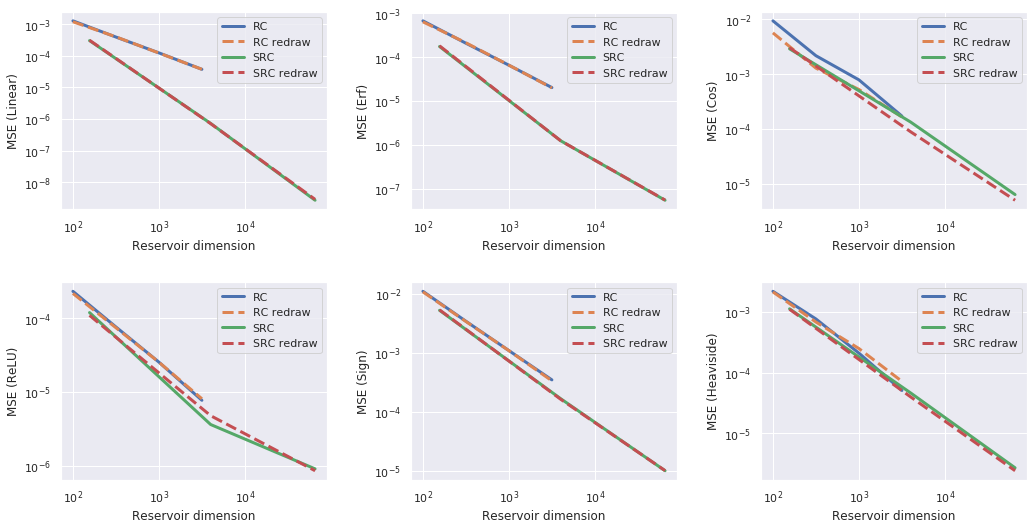

In [51]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

axes[0,0].loglog(rc_res_range, np.mean(lin_rc, axis=2).T, linewidth=3)
axes[0,0].loglog(rc_res_range, np.mean(lin_rc_r, axis=2).T, '--', linewidth=3)
axes[0,0].loglog(src_res_range[:3], np.mean(lin_src, axis=2).T[:3], linewidth=3)
axes[0,0].loglog(src_res_range[:3], np.mean(lin_src_r, axis=2).T[:3], '--', linewidth=3)
axes[0,0].set_xlabel('Reservoir dimension')
axes[0,0].set_ylabel('MSE (Linear)')
axes[0,0].legend(['RC', 'RC redraw', 'SRC', 'SRC redraw']);

axes[0,1].loglog(rc_res_range, np.mean(erf_rc, axis=2).T, linewidth=3)
axes[0,1].loglog(rc_res_range, np.mean(erf_rc_r, axis=2).T, '--', linewidth=3)
axes[0,1].loglog(src_res_range[:3], np.mean(erf_src, axis=2).T[:3], linewidth=3)
axes[0,1].loglog(src_res_range[:3], np.mean(erf_src_r, axis=2).T[:3], '--', linewidth=3)
axes[0,1].set_xlabel('Reservoir dimension')
axes[0,1].set_ylabel('MSE (Erf)')
axes[0,1].legend(['RC', 'RC redraw', 'SRC', 'SRC redraw']);

axes[0,2].loglog(rc_res_range, np.mean(cos_rc, axis=2).T, linewidth=3)
axes[0,2].loglog(rc_res_range, np.mean(cos_rc_r, axis=2).T, '--', linewidth=3)
axes[0,2].loglog(src_res_range[:3], np.mean(cos_src, axis=2).T[:3], linewidth=3)
axes[0,2].loglog(src_res_range[:3], np.mean(cos_src_r, axis=2).T[:3], '--', linewidth=3)
axes[0,2].set_xlabel('Reservoir dimension')
axes[0,2].set_ylabel('MSE (Cos)')
axes[0,2].legend(['RC', 'RC redraw', 'SRC', 'SRC redraw']);

axes[1,0].loglog(rc_res_range, np.mean(relu_rc, axis=2).T, linewidth=3)
axes[1,0].loglog(rc_res_range, np.mean(relu_rc_r, axis=2).T, '--', linewidth=3)
axes[1,0].loglog(src_res_range[:3], np.mean(relu_src, axis=2).T[:3], linewidth=3)
axes[1,0].loglog(src_res_range[:3], np.mean(relu_src_r, axis=2).T[:3], '--', linewidth=3)
axes[1,0].set_xlabel('Reservoir dimension')
axes[1,0].set_ylabel('MSE (ReLU)')
axes[1,0].legend(['RC', 'RC redraw', 'SRC', 'SRC redraw']);

axes[1,1].loglog(rc_res_range, np.mean(sign_rc, axis=2).T, linewidth=3)
axes[1,1].loglog(rc_res_range, np.mean(sign_rc_r, axis=2).T, '--', linewidth=3)
axes[1,1].loglog(src_res_range[:3], np.mean(sign_src, axis=2).T[:3], linewidth=3)
axes[1,1].loglog(src_res_range[:3], np.mean(sign_src_r, axis=2).T[:3], '--', linewidth=3)
axes[1,1].set_xlabel('Reservoir dimension')
axes[1,1].set_ylabel('MSE (Sign)')
axes[1,1].legend(['RC', 'RC redraw', 'SRC', 'SRC redraw']);

axes[1,2].loglog(rc_res_range, np.mean(heav_rc, axis=2).T, linewidth=3)
axes[1,2].loglog(rc_res_range, np.mean(heav_rc_r, axis=2).T, '--', linewidth=3)
axes[1,2].loglog(src_res_range[:3], np.mean(heav_src, axis=2).T[:3], linewidth=3)
axes[1,2].loglog(src_res_range[:3], np.mean(heav_src_r, axis=2).T[:3], '--', linewidth=3)
axes[1,2].set_xlabel('Reservoir dimension')
axes[1,2].set_ylabel('MSE (Heaviside)')
axes[1,2].legend(['RC', 'RC redraw', 'SRC', 'SRC redraw'])

fig.tight_layout(pad=3.0);